### Run the next cell first, to be in the correct direcotry

In [1]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")

Changed to: /Users/maximilianjoas/development/autoencodix_package


### Test Data With Varix

In [2]:
import autoencodix as acx
from autoencodix.configs import VarixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase

sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = VarixConfig(
    epochs=50,
    checkpoint_interval=10,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
varix = acx.Varix(config=config)

In [3]:
result = varix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
Epoch 1 - Train Loss: 24.7379
Sub-losses: recon_loss: 24.7379, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 24.3436
Sub-losses: recon_loss: 24.3434, var_loss: 0.0001, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 20.8434
Sub-losses: recon_loss: 20.8434, var_loss: 0.0001, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 21.1790
Sub-losses: recon_loss: 21.1790, var_loss: 0.0000, anneal_factor: 0.

Creating plots ...


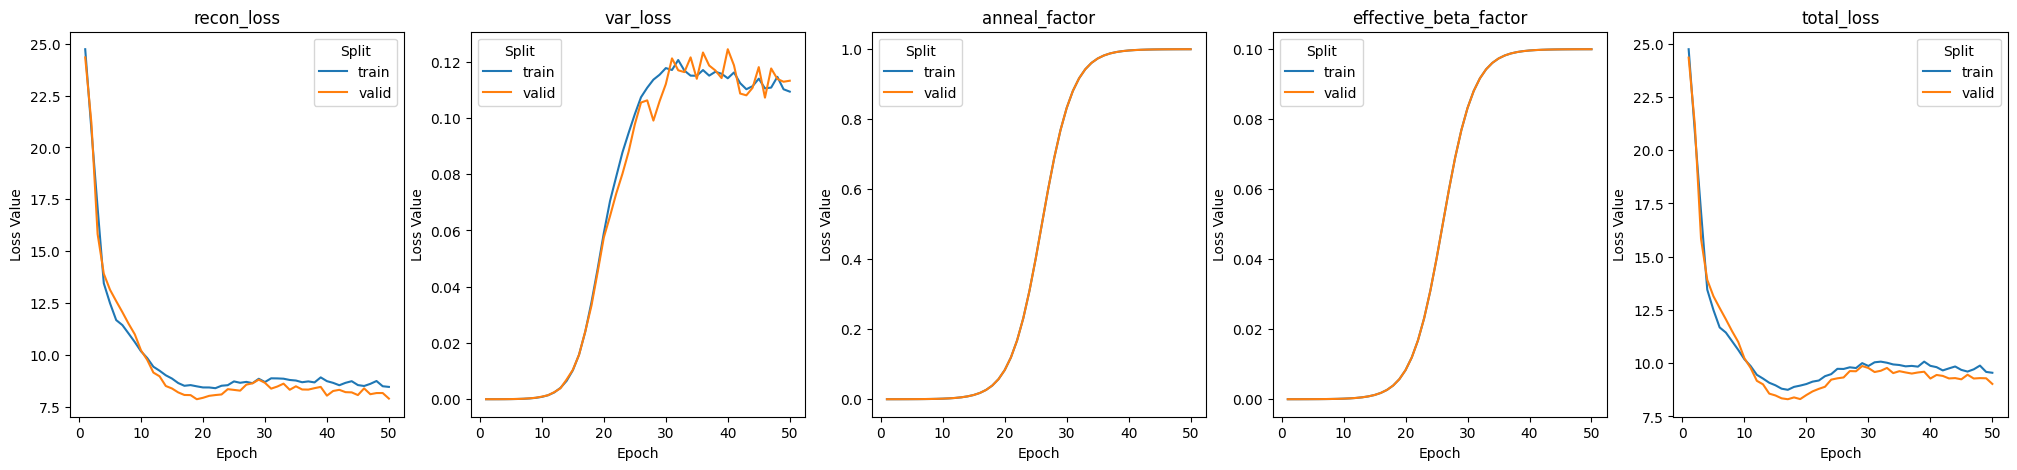

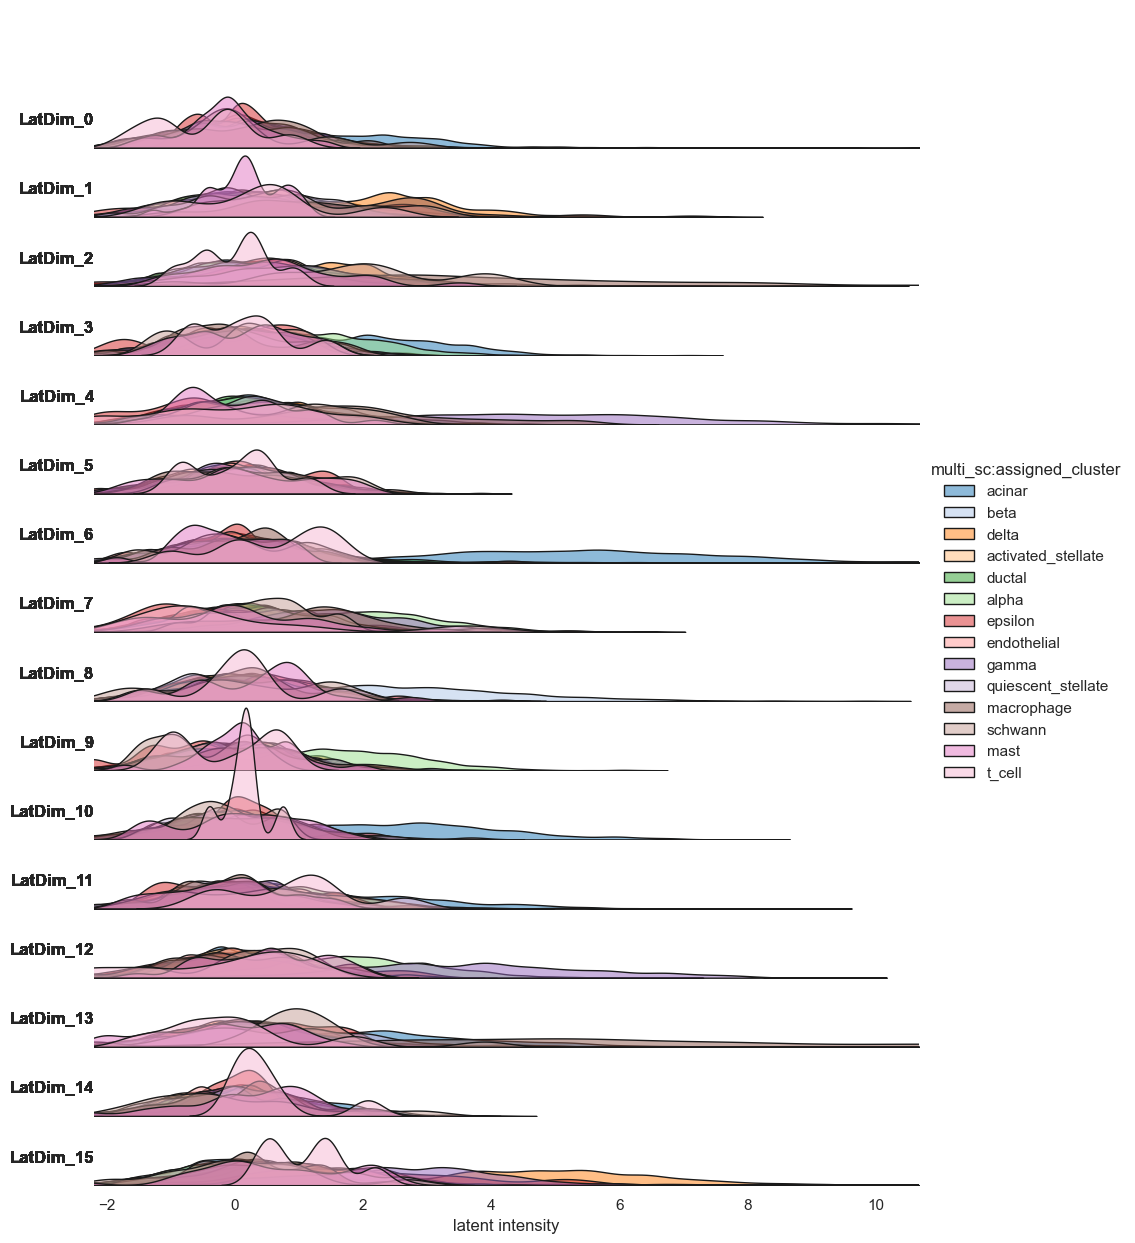

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


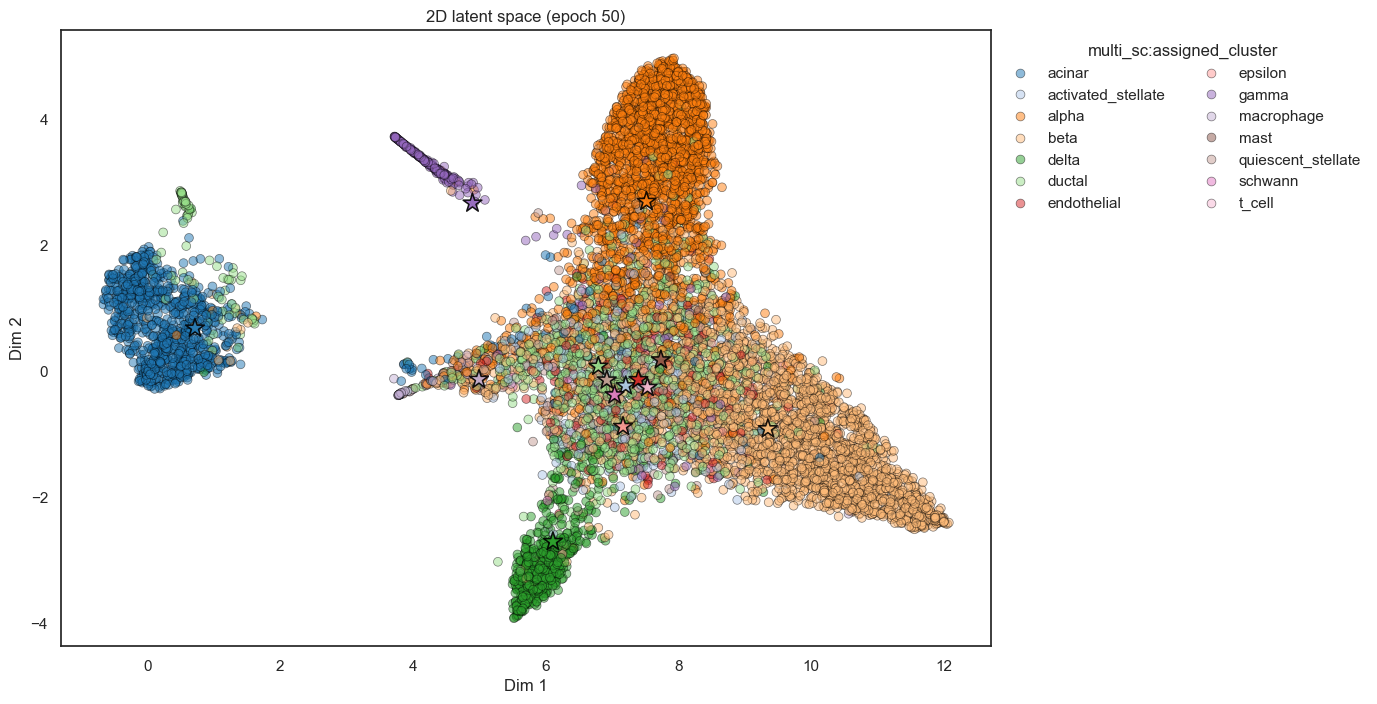

In [4]:
varix.show_result()

#### Potential Bug in Paper
The authors write their shuffle the samples independent per gene, but the code suggests dependent shuffling, see below.

In [5]:
for _, batch, _ in varix._trainer._trainloader:
    print(batch)
    break

tensor([[-0.5776, -0.2724, -0.4779,  ..., -0.0812, -0.0874, -0.3261],
        [-0.5828, -0.2797, -0.4954,  ..., -0.1138, 13.3040, -0.3261],
        [ 1.4626, -0.2630, -0.4921,  ..., -0.1138, -0.2534, -0.3261],
        ...,
        [-0.5771, -0.2791, -0.4788,  ..., -0.1138, -0.2432, -0.3261],
        [-0.5677, -0.2783,  2.5001,  ..., -0.1138, -0.0985, -0.3261],
        [-0.5798, -0.2818, -0.4919,  ..., -0.1008, -0.2915,  2.5302]],
       device='mps:0')


In [6]:
import torch


def apply_noise(X, p=[0.2, 0.4]):
    p = torch.tensor(p)
    should_swap = torch.bernoulli(p.to(X.device) * torch.ones((X.shape)).to(X.device))
    permut = torch.randperm(X.shape[0])
    print(permut)
    corrupted_X = torch.where(should_swap == 1, X[permut], X)
    print(corrupted_X)
    masked = (corrupted_X != X).float()
    return corrupted_X, masked


In [7]:
batch.shape

torch.Size([64, 20])

In [8]:
batch

tensor([[-0.5776, -0.2724, -0.4779,  ..., -0.0812, -0.0874, -0.3261],
        [-0.5828, -0.2797, -0.4954,  ..., -0.1138, 13.3040, -0.3261],
        [ 1.4626, -0.2630, -0.4921,  ..., -0.1138, -0.2534, -0.3261],
        ...,
        [-0.5771, -0.2791, -0.4788,  ..., -0.1138, -0.2432, -0.3261],
        [-0.5677, -0.2783,  2.5001,  ..., -0.1138, -0.0985, -0.3261],
        [-0.5798, -0.2818, -0.4919,  ..., -0.1008, -0.2915,  2.5302]],
       device='mps:0')

In [9]:
apply_noise(batch, p=0.4)

tensor([50, 49, 16, 26, 19, 25, 29,  6, 22, 41,  2, 20, 24, 12,  0, 37, 55, 42,
        13, 52, 54, 35, 60, 48, 39, 27,  9, 59, 18, 34, 15, 46, 33, 47, 45, 61,
         3, 38, 31, 51, 30,  4, 14, 58, 57, 17, 10,  8, 32, 21,  5, 28, 23, 53,
        40, 62, 43, 63,  7, 36, 11, 44,  1, 56])
tensor([[-0.5776, -0.2686, -0.4851,  ..., -0.1138, -0.1716, -0.3261],
        [-0.5828, -0.2797, -0.4954,  ..., -0.1138, 13.3040, -0.3261],
        [ 1.4626, -0.2630, -0.4921,  ..., -0.1138, -0.2560, -0.3261],
        ...,
        [-0.5597, -0.2791, -0.4802,  ..., -0.1138, -0.2326, -0.3261],
        [-0.5828, -0.2783,  2.5001,  ..., -0.1138, -0.0985, -0.3261],
        [-0.5798, -0.2818, -0.4919,  ..., -0.1138, -0.2085,  2.5302]],
       device='mps:0')


(tensor([[-0.5776, -0.2686, -0.4851,  ..., -0.1138, -0.1716, -0.3261],
         [-0.5828, -0.2797, -0.4954,  ..., -0.1138, 13.3040, -0.3261],
         [ 1.4626, -0.2630, -0.4921,  ..., -0.1138, -0.2560, -0.3261],
         ...,
         [-0.5597, -0.2791, -0.4802,  ..., -0.1138, -0.2326, -0.3261],
         [-0.5828, -0.2783,  2.5001,  ..., -0.1138, -0.0985, -0.3261],
         [-0.5798, -0.2818, -0.4919,  ..., -0.1138, -0.2085,  2.5302]],
        device='mps:0'),
 tensor([[0., 1., 1.,  ..., 1., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 0., 1.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 0.]], device='mps:0'))

#### Correction


In [10]:
from typing import List

X = batch
print(f"batch shape: {X.shape}")
mask_probas_list: List[float] = [
    varix.config.maskix_swap_prob
] * varix._trainer._model.input_dim
mask_probas = torch.tensor(mask_probas_list).to(varix._trainer._model.device)
print(f"mask_probas shape: {mask_probas.shape}")


probs = mask_probas.expand(X.shape)
print(f"probs shape after expand: {probs.shape}")

should_swap = torch.bernoulli(probs).bool()

rand_indices = torch.rand(X.shape, device=X.device).argsort(dim=0)
print(f"rand_indices : {rand_indices}")

shuffled_X = torch.gather(X, 0, rand_indices)
print(f"shuffled_X: {shuffled_X}")
corrupted_X = torch.where(should_swap, shuffled_X, X)
print(f"corrupted_X: {corrupted_X}")


batch shape: torch.Size([64, 20])
mask_probas shape: torch.Size([20])
probs shape after expand: torch.Size([64, 20])
rand_indices : tensor([[15,  5, 50,  ...,  9, 61, 56],
        [ 3, 62, 24,  ..., 62,  3,  9],
        [54, 60, 59,  ..., 45, 12, 46],
        ...,
        [53, 55, 56,  ..., 35, 43, 30],
        [37, 57,  4,  ..., 42, 25,  1],
        [10, 50, 33,  ..., 51, 33, 47]], device='mps:0')
shuffled_X: tensor([[-0.5822, -0.2394, -0.4851,  ..., -0.1138, -0.2432, -0.3261],
        [-0.5718, -0.2783, -0.4918,  ..., -0.1138, -0.0055, -0.3261],
        [-0.5814, -0.2355, -0.4916,  ..., -0.1138, -0.2220, -0.3261],
        ...,
        [-0.5841, -0.2818, -0.4954,  ..., -0.1138,  0.3583, -0.0788],
        [-0.5772, -0.2818, -0.4954,  ..., -0.1138,  0.2429, -0.3261],
        [ 1.1250, -0.2686, -0.4475,  ..., -0.1138, -0.2915, -0.3261]],
       device='mps:0')
corrupted_X: tensor([[-0.5822, -0.2394, -0.4851,  ..., -0.0812, -0.0874, -0.3261],
        [-0.5828, -0.2783, -0.4918,  ..., -0.1

In [11]:
import torch

rand_indices = torch.rand(X.shape, device=X.device).argsort(dim=0)
print(f"rand_indices : {rand_indices}")


rand_indices : tensor([[38, 28, 24,  ..., 51, 19, 15],
        [22, 16, 17,  ..., 38,  2,  3],
        [46, 13, 18,  ..., 21,  7, 56],
        ...,
        [28, 38, 56,  ..., 48, 12, 12],
        [62, 24, 23,  ..., 28, 63, 37],
        [54, 35, 16,  ..., 23, 54, 16]], device='mps:0')


In [12]:
rand_indices.shape

torch.Size([64, 20])

In [13]:
shuffled_X = torch.gather(X, 0, rand_indices)

In [14]:
print(f"shuffled_X: {shuffled_X}")

shuffled_X: tensor([[ 0.5467, -0.2693, -0.4918,  ..., -0.1138, -0.1914, -0.3261],
        [ 2.6423, -0.2594, -0.4954,  ..., -0.1138, -0.2534, -0.1170],
        [ 1.0407, -0.2732, -0.4934,  ..., -0.1138, -0.2094, -0.3261],
        ...,
        [-0.5808, -0.2436, -0.4954,  ..., -0.1138, -0.2220, -0.3261],
        [-0.5677, -0.2750, -0.4905,  ..., -0.1138, -0.2915, -0.3261],
        [-0.5814, -0.2818, -0.4908,  ..., -0.1138, -0.2591, -0.3261]],
       device='mps:0')


In [15]:
torch.rand(X.shape, device=X.device)

tensor([[0.6963, 0.4815, 0.9519,  ..., 0.6053, 0.2469, 0.2717],
        [0.1075, 0.4593, 0.7504,  ..., 0.3725, 0.3196, 0.4324],
        [0.7050, 0.4059, 0.6870,  ..., 0.2413, 0.7498, 0.6206],
        ...,
        [0.3388, 0.7343, 0.5054,  ..., 0.5712, 0.0150, 0.2584],
        [0.1340, 0.7369, 0.0682,  ..., 0.7038, 0.0707, 0.2609],
        [0.3443, 0.2771, 0.9130,  ..., 0.6864, 0.1978, 0.6659]],
       device='mps:0')

## Test Maskix Pipeline

In [2]:
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase

sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = MaskixConfig(
    epochs=2,
    checkpoint_interval=1,
    n_layers=3,
    k_filter=1000,
    maskix_architecture="custom",
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
maskix = acx.Maskix(config=config)

In [5]:
maskix.config.n_layers=0

In [3]:
maskix_result = maskix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 420.1958
Sub-losses: recon_loss: 314.0631, mask_loss: 465.6813
Epoch 1 - Valid Loss: 352.6566
Sub-losses: recon_loss: 296.7525, mask_loss: 376.6156
Epoch 2 - Train Loss: 349.8766
Sub-losses: recon_loss: 283.9036, mask_loss: 378.1508
Epoch 2 - Valid Loss: 346.6816
Sub-losses: recon_loss: 283.7691, mask_loss: 373.6440


In [6]:
maskix.fit()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 577.2345
Sub-losses: recon_loss: 324.9929, mask_loss: 685.3380
Epoch 1 - Valid Loss: 558.1843
Sub-losses: recon_loss: 309.2875, mask_loss: 664.8544
Epoch 2 - Train Loss: 540.6616
Sub-losses: recon_loss: 297.5661, mask_loss: 644.8453
Epoch 2 - Valid Loss: 517.9482
Sub-losses: recon_loss: 295.7254, mask_loss: 613.1866


In [7]:
maskix.result.model

MaskixArchitectureVanilla(
  (_mask_predictor): Linear(in_features=16, out_features=1000, bias=True)
  (_encoder): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=1000, out_features=16, bias=True)
  )
  (_decoder): Sequential(
    (0): Linear(in_features=1016, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=1000, bias=True)
  )
)

In [13]:
maskix.config.n_layers=0
maskix.fit()
maskix.result.model

Epoch 1 - Train Loss: 576.7528
Sub-losses: recon_loss: 323.1603, mask_loss: 685.4353
Epoch 1 - Valid Loss: 556.6226
Sub-losses: recon_loss: 305.7699, mask_loss: 664.1310
Epoch 2 - Train Loss: 542.3540
Sub-losses: recon_loss: 301.5958, mask_loss: 645.5362
Epoch 2 - Valid Loss: 516.8976
Sub-losses: recon_loss: 297.3409, mask_loss: 610.9933


MaskixArchitectureVanilla(
  (_mask_predictor): Linear(in_features=16, out_features=1000, bias=True)
  (_encoder): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=1000, out_features=16, bias=True)
  )
  (_decoder): Sequential(
    (0): Linear(in_features=1016, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=1000, bias=True)
  )
)

Creating plots ...


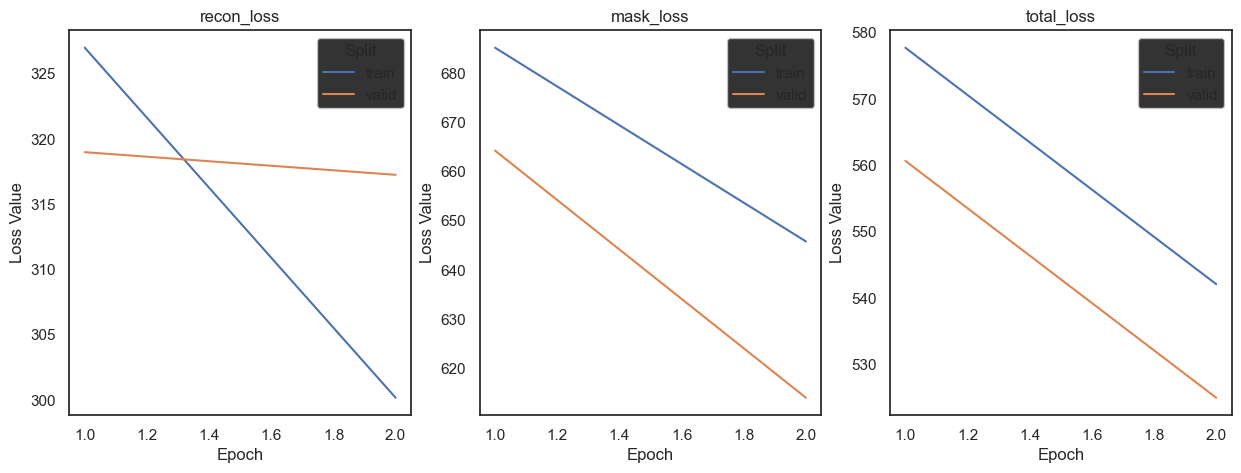

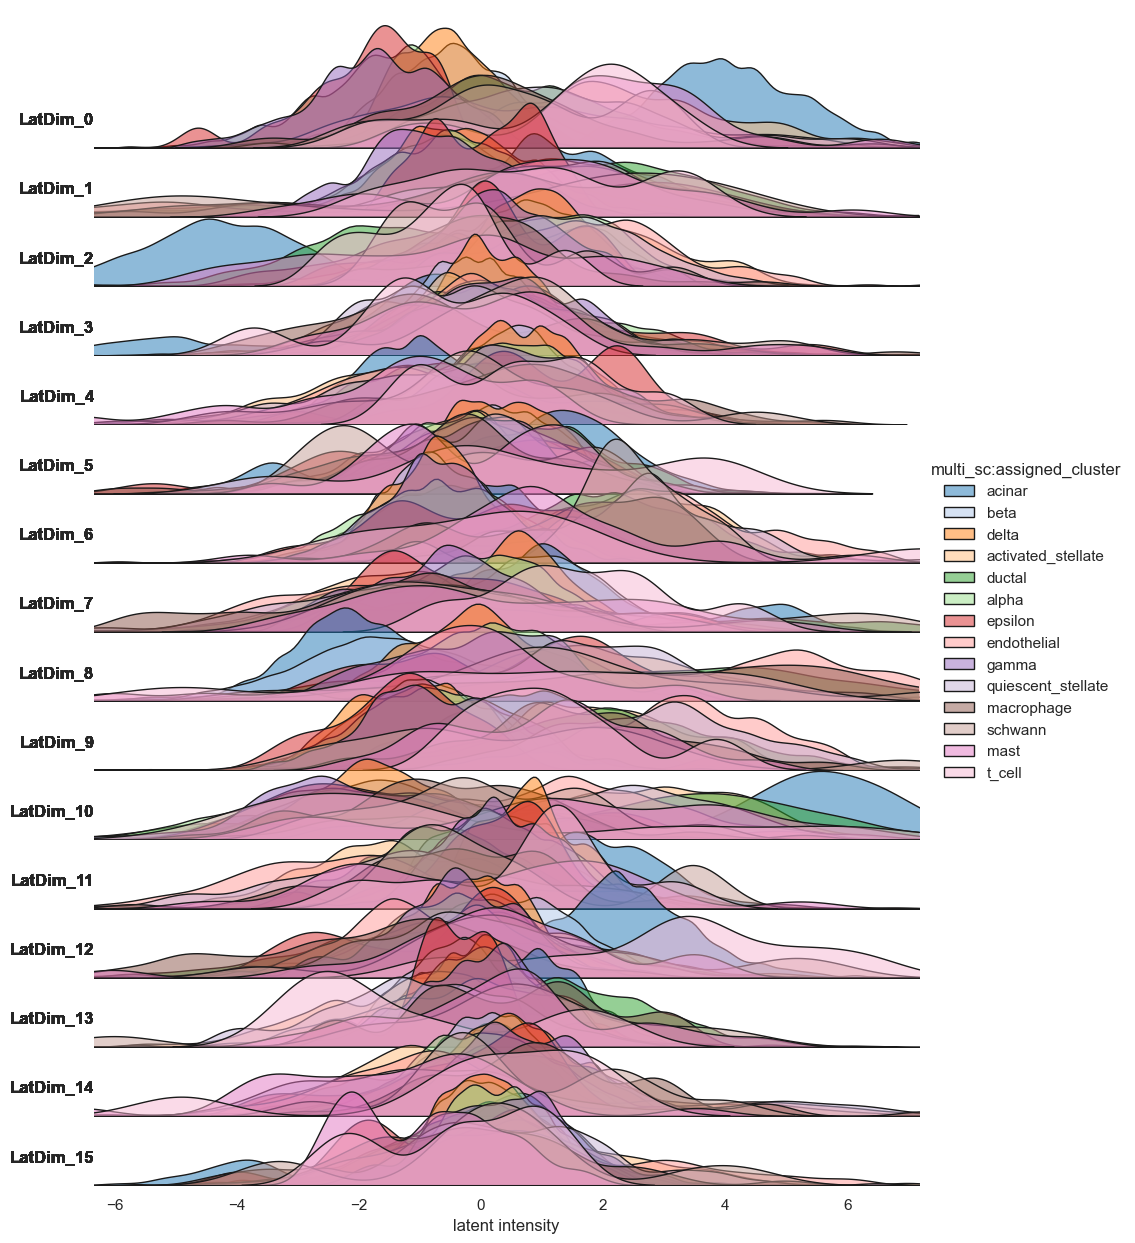

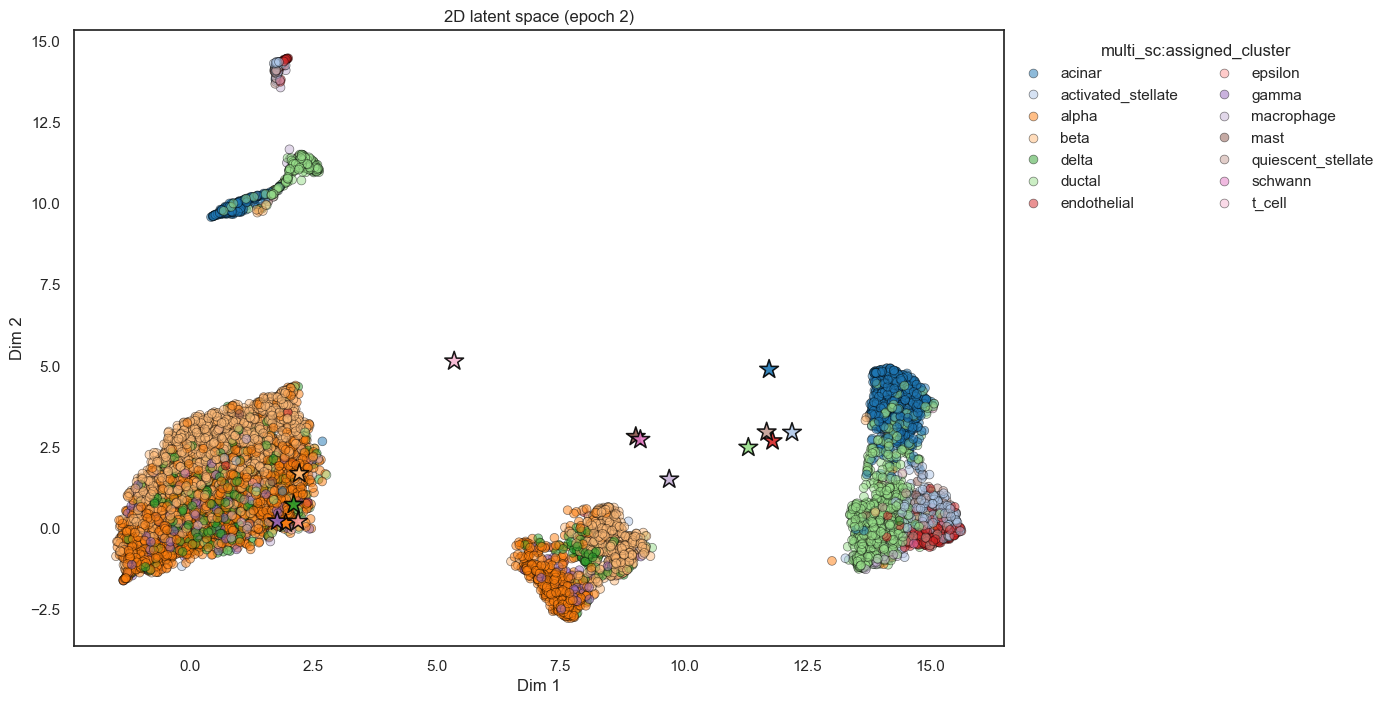

In [21]:
maskix.show_result()

In [22]:
config.latent_dim

16

### Consitency Check
We will gradually increase the probablity of masking, to see if the masking works as intended. We expect the Maskix to be similar to the Vanillix for propabilties near zero and to  be not working at all for probablities near 1

##### Vanillix Baseline


In [23]:
import autoencodix as acx
from autoencodix.data.datapackage import DataPackage
from autoencodix.configs.vanillix_config import VanillixConfig
from autoencodix.configs.default_config import DataCase


config = VanillixConfig(
    epochs=50,
    checkpoint_interval=10,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
vanillix = acx.Vanillix(config=config)

In [24]:
result_vanillix = vanillix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
Epoch 1 - Train Loss: 19.7332
Sub-losses: recon_loss: 19.7332
Epoch 1 - Valid Loss: 14.8864
Sub-losses: recon_loss: 14.8864
Epoch 2 - Train Loss: 13.2956
Sub-losses: recon_loss: 13.2956
Epoch 2 - Valid Loss: 12.4377
Sub-losses: recon_loss: 12.4377
Epoch 3 - Train Loss: 11.8108
Sub-losses: recon_loss: 11.8108
Epoch 3 - Valid Loss: 11.4465
Sub-losses: recon_loss: 11.4465
Epoch 4 - Train Loss: 10.8837
Sub-losses: recon_loss: 10.8837
Epoch 4 - Valid Loss: 10.4976
Sub-losses: recon_loss: 10.4976
Epoc

Creating plots ...


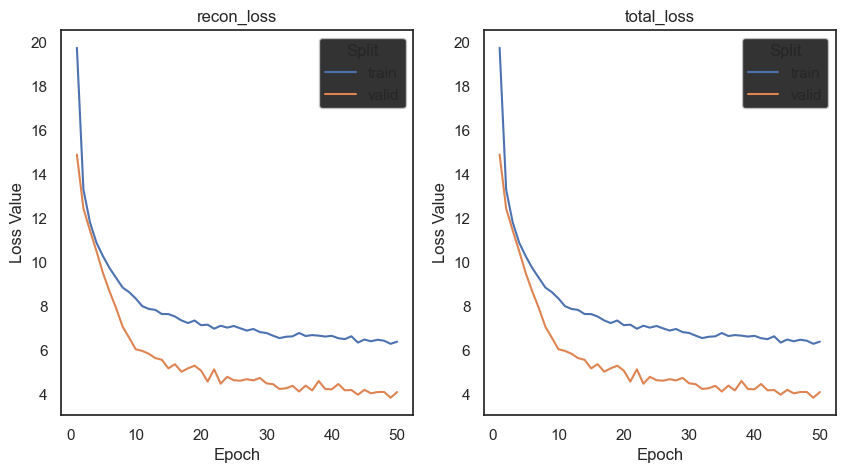

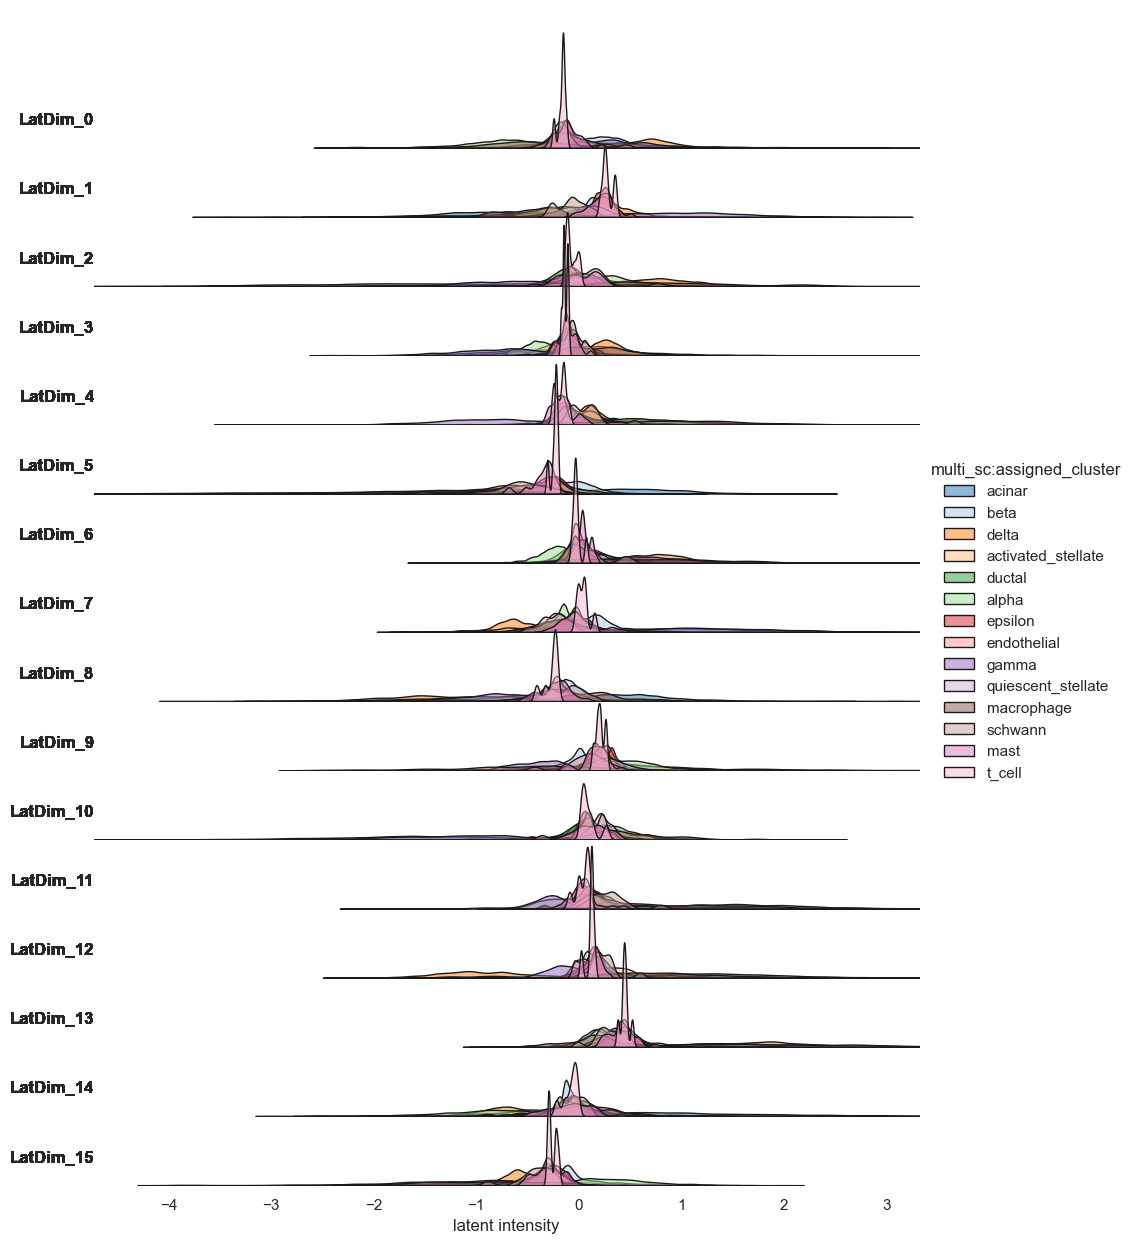

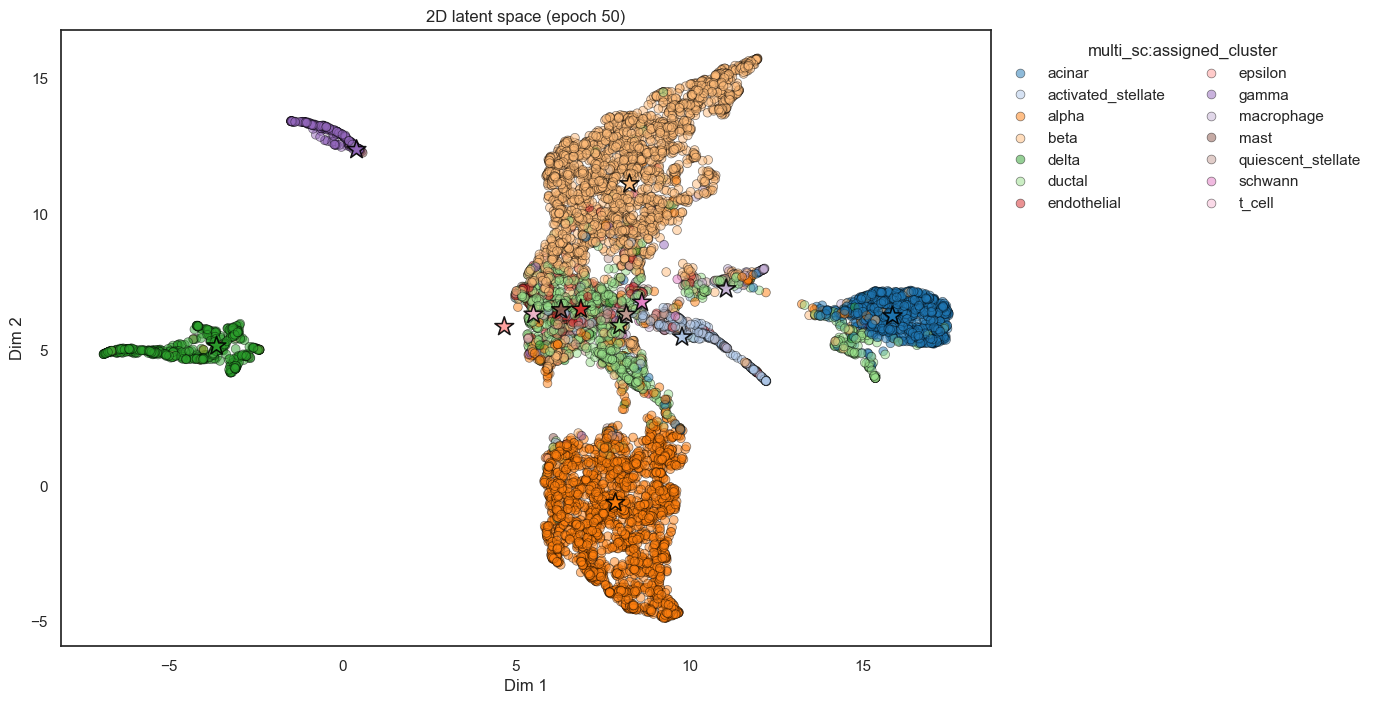

In [25]:
vanillix.show_result()

### Maskix Checks

In [26]:
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase


probs = [0.0, 0.3, 0.6, 1.0]
pipelines = {}
for p in probs:
    sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
    config = MaskixConfig(
        epochs=50,
        checkpoint_interval=10,
        batch_size=64,
        maskix_swap_prob=p,
        data_config=DataConfig(
            annotation_columns=["multi_sc:assigned_cluster"],
            data_info={
                "multi_sc": DataInfo(
                    file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
                )
            },
        ),
        data_case=DataCase.MULTI_SINGLE_CELL,
    )
    maskix = acx.Maskix(config=config)
    result = maskix.run()
    pipelines[str(p)] = maskix

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 5.9818
Sub-losses: recon_loss: 4.9696, mask_loss: 6.4156
Epoch 1 - Valid Loss: 2.2318
Sub-losses: recon_loss: 4.2730, mask_loss: 1.3570
Epoch 2 - Train Loss: 1.3036
Sub-losses: recon_loss: 2.9492, mask_loss: 0.5983
Epoch 2 - Valid Loss: 1.1151
Sub-losses: recon_loss: 3.1051, mask_loss: 0.2623
Epoch 3 - Train Loss: 0.8024
Sub-losses: recon_loss: 2.2655, mask_loss: 0.1753
Epoch 3 - Valid Loss: 0.8412
Sub-losses: recon_loss: 2.5257, mask_loss: 0.1193
Epoch 4 - Train Loss: 0.6341
Sub-losses: recon_loss: 1.8982, mask_loss: 0.0924
Epoch 4 - Valid Loss: 0.6918
Sub-losses: recon_loss: 2.1271, mask_loss: 0.0767
Epoch 5 - Train Loss: 0.5332
Sub-losses: recon_loss: 1.6390, mask_loss: 0.0593
Epoch 5 - Valid Loss: 0.5924
Sub-losses: recon_loss: 1.8534, mask_loss: 0.0520
Epoch 6 - Train Loss: 0.4739
Sub-losses: recon_loss: 1.4829, mask_loss: 0.0415
Epoch 6 - Valid Loss: 0.5217
Sub-losses: recon_loss: 1.6534, mask_loss: 0.0367
Epoch 7 - Train Loss: 0.4234
Sub-losses: recon_loss:

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 10.7752
Sub-losses: recon_loss: 7.5873, mask_loss: 12.1415
Epoch 1 - Valid Loss: 9.1677
Sub-losses: recon_loss: 6.8229, mask_loss: 10.1726
Epoch 2 - Train Loss: 8.6305
Sub-losses: recon_loss: 5.1727, mask_loss: 10.1124
Epoch 2 - Valid Loss: 8.6278
Sub-losses: recon_loss: 6.2301, mask_loss: 9.6553
Epoch 3 - Train Loss: 8.4306
Sub-losses: recon_loss: 4.9587, mask_loss: 9.9185
Epoch 3 - Valid Loss: 8.3758
Sub-losses: recon_loss: 5.7019, mask_loss: 9.5218
Epoch 4 - Train Loss: 8.3368
Sub-losses: recon_loss: 4.7223, mask_loss: 9.8859
Epoch 4 - Valid Loss: 8.3363
Sub-losses: recon_loss: 5.4600, mask_loss: 9.5690
Epoch 5 - Train Loss: 8.2219
Sub-losses: recon_loss: 4.5510, mask_loss: 9.7952
Epoch 5 - Valid Loss: 8.2805
Sub-losses: recon_loss: 5.5142, mask_loss: 9.4661
Epoch 6 - Train Loss: 8.1654
Sub-losses: recon_loss: 4.4443, mask_loss: 9.7601
Epoch 6 - Valid Loss: 8.2527
Sub-losses: recon_loss: 5.3181, mask_loss: 9.5103
Epoch 7 - Train Loss: 8.1245
Sub-losses: recon_l

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


Epoch 1 - Train Loss: 12.6836
Sub-losses: recon_loss: 10.6401, mask_loss: 13.5594
Epoch 1 - Valid Loss: 11.8548
Sub-losses: recon_loss: 9.9628, mask_loss: 12.6656
Epoch 2 - Train Loss: 11.4318
Sub-losses: recon_loss: 8.4340, mask_loss: 12.7166
Epoch 2 - Valid Loss: 11.5187
Sub-losses: recon_loss: 9.8886, mask_loss: 12.2174
Epoch 3 - Train Loss: 11.2866
Sub-losses: recon_loss: 8.2879, mask_loss: 12.5717
Epoch 3 - Valid Loss: 11.3012
Sub-losses: recon_loss: 9.3568, mask_loss: 12.1345
Epoch 4 - Train Loss: 11.1283
Sub-losses: recon_loss: 7.8939, mask_loss: 12.5145
Epoch 4 - Valid Loss: 11.4205
Sub-losses: recon_loss: 9.7594, mask_loss: 12.1323
Epoch 5 - Train Loss: 11.1399
Sub-losses: recon_loss: 8.1158, mask_loss: 12.4359
Epoch 5 - Valid Loss: 11.2841
Sub-losses: recon_loss: 9.5138, mask_loss: 12.0428
Epoch 6 - Train Loss: 11.0636
Sub-losses: recon_loss: 7.8489, mask_loss: 12.4413
Epoch 6 - Valid Loss: 11.0372
Sub-losses: recon_loss: 8.8040, mask_loss: 11.9943
Epoch 7 - Train Loss: 11.04

KeyboardInterrupt: 

Creating plots ...


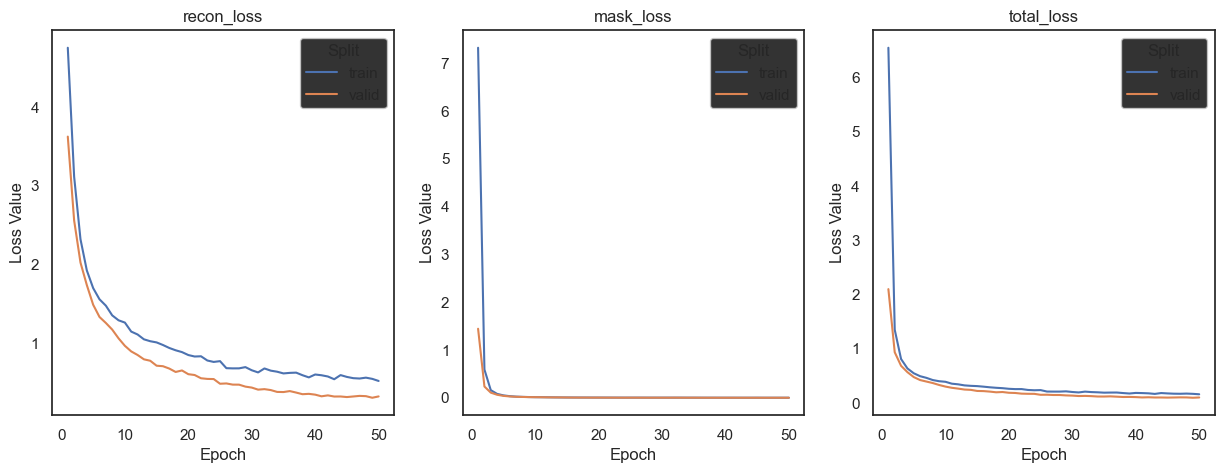

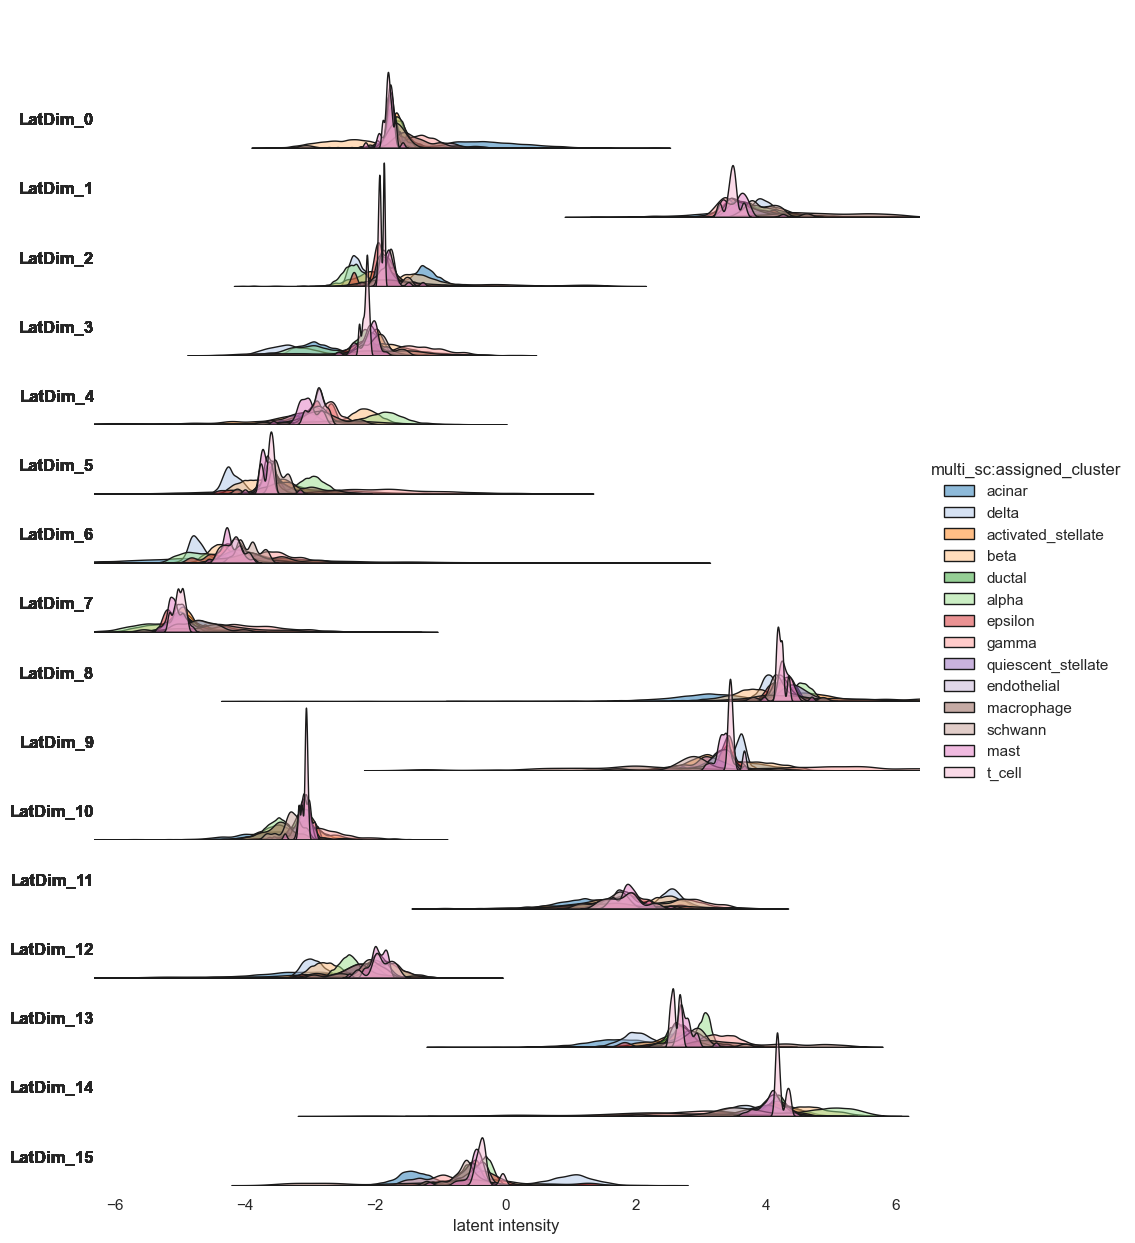

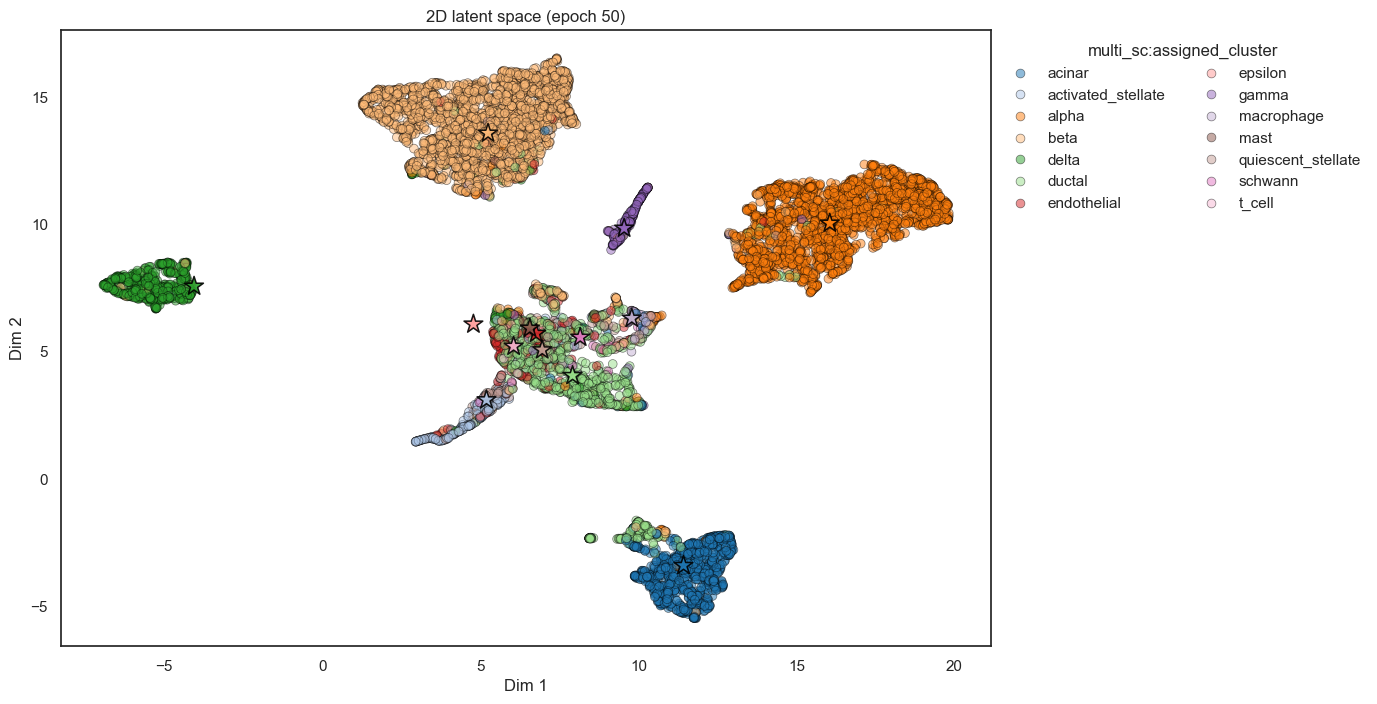

In [ ]:
maskix_zero = pipelines["0.0"]
maskix_zero.show_result()

Creating plots ...


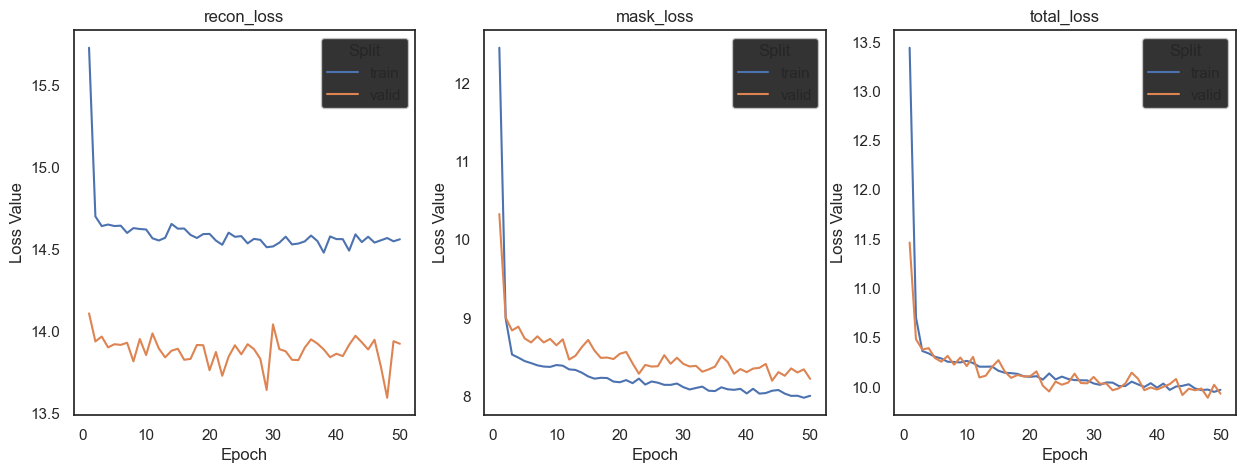

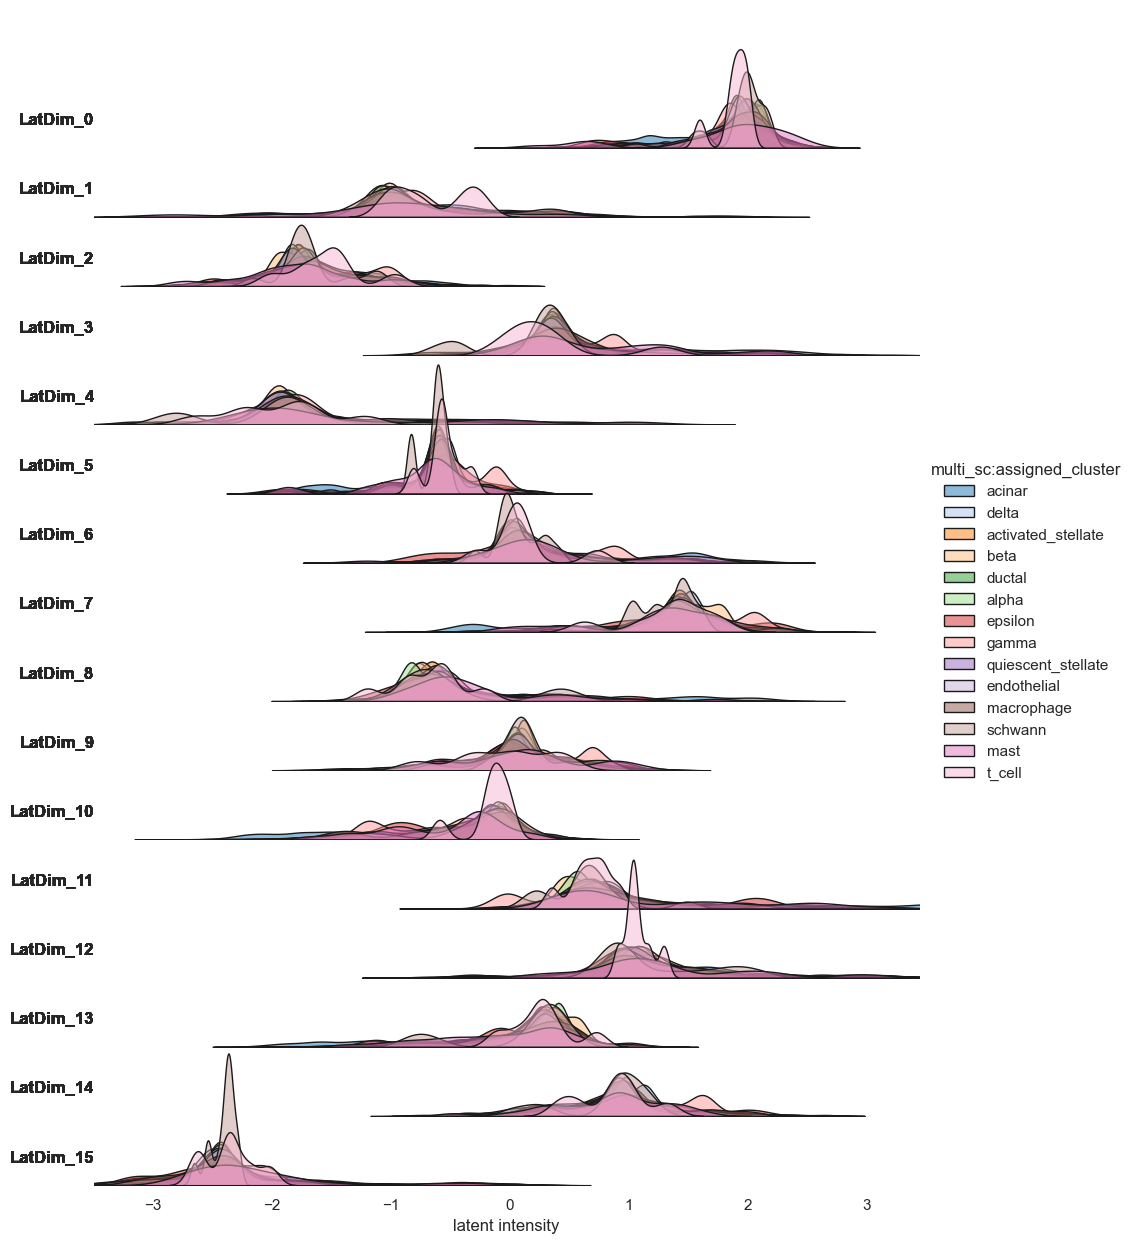

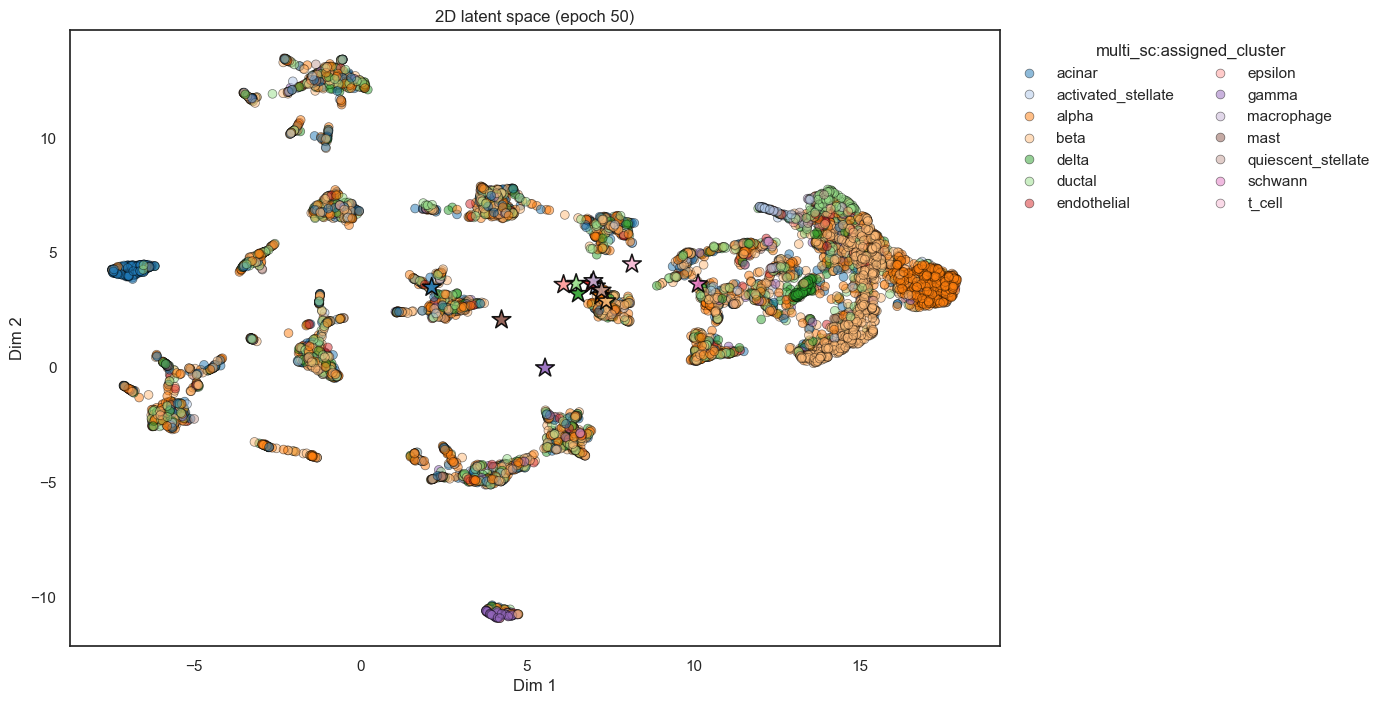

In [ ]:
maskix_zero = pipelines["1.0"]
maskix_zero.show_result()

Creating plots ...


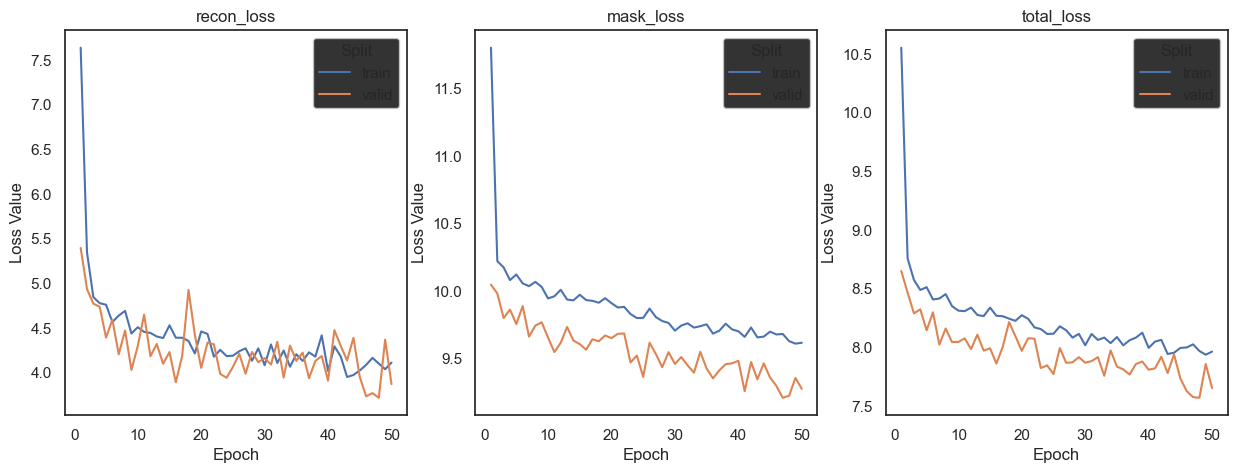

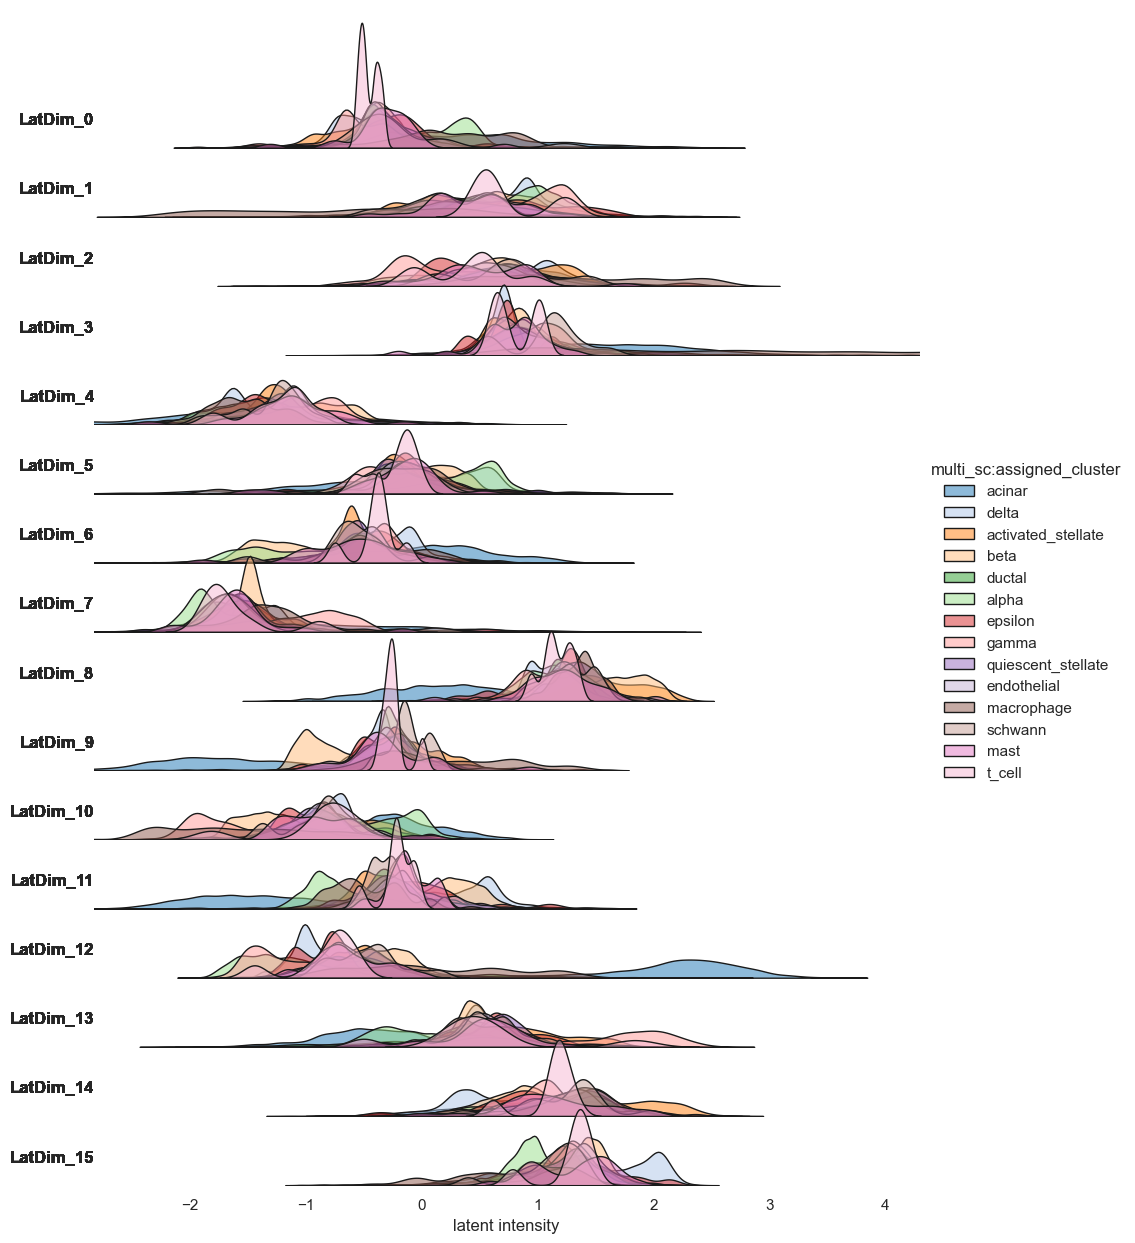

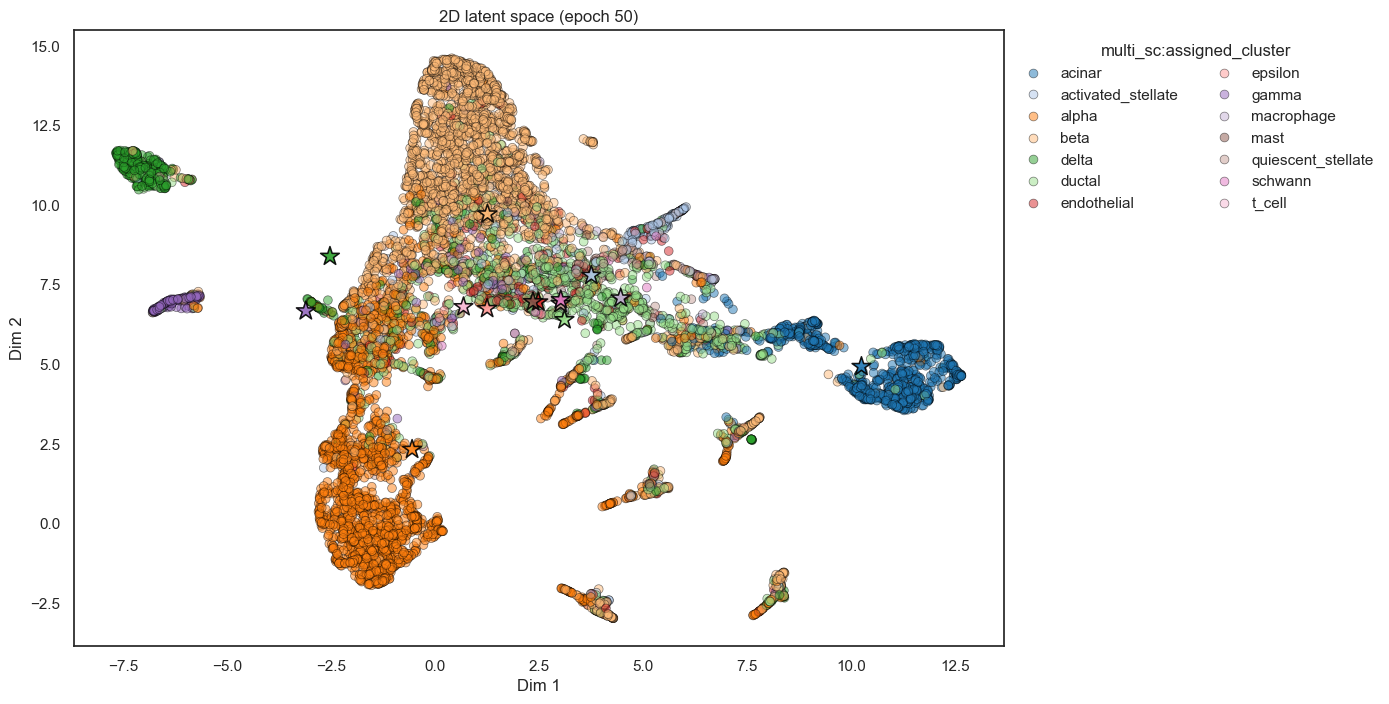

In [ ]:
maskix_zero = pipelines["0.3"]
maskix_zero.show_result()

Creating plots ...


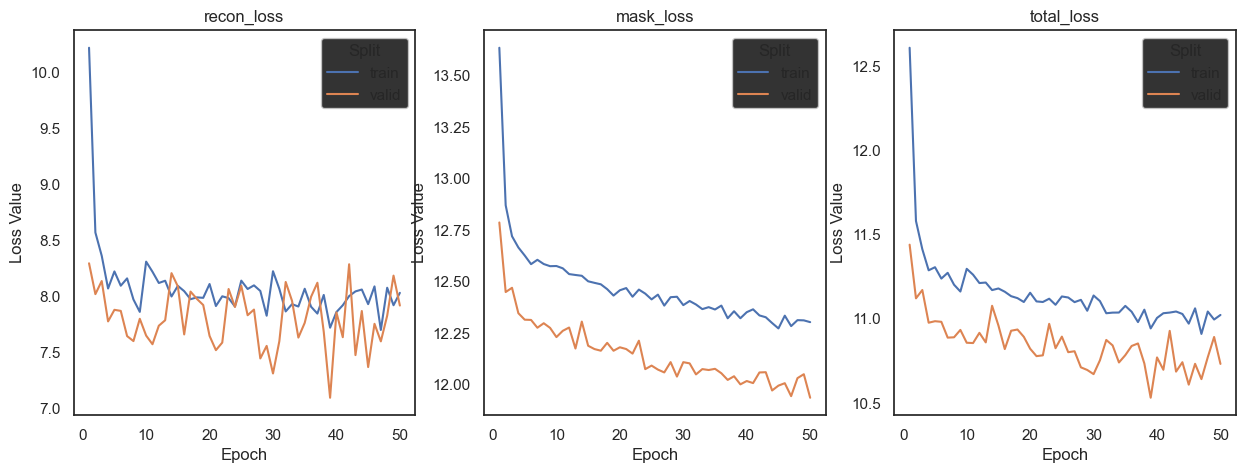

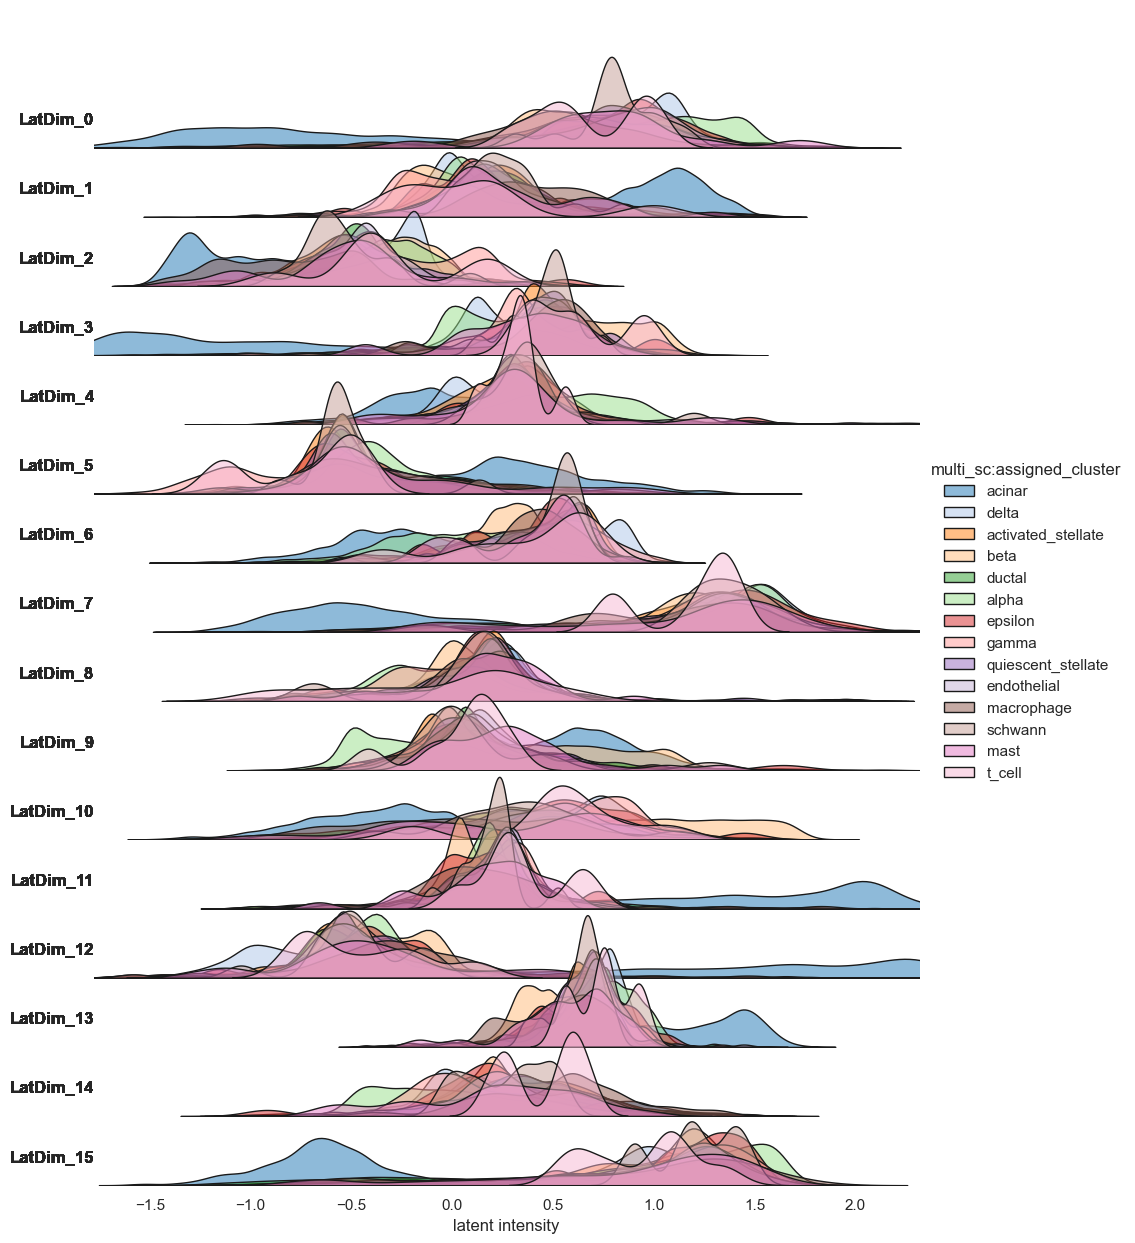

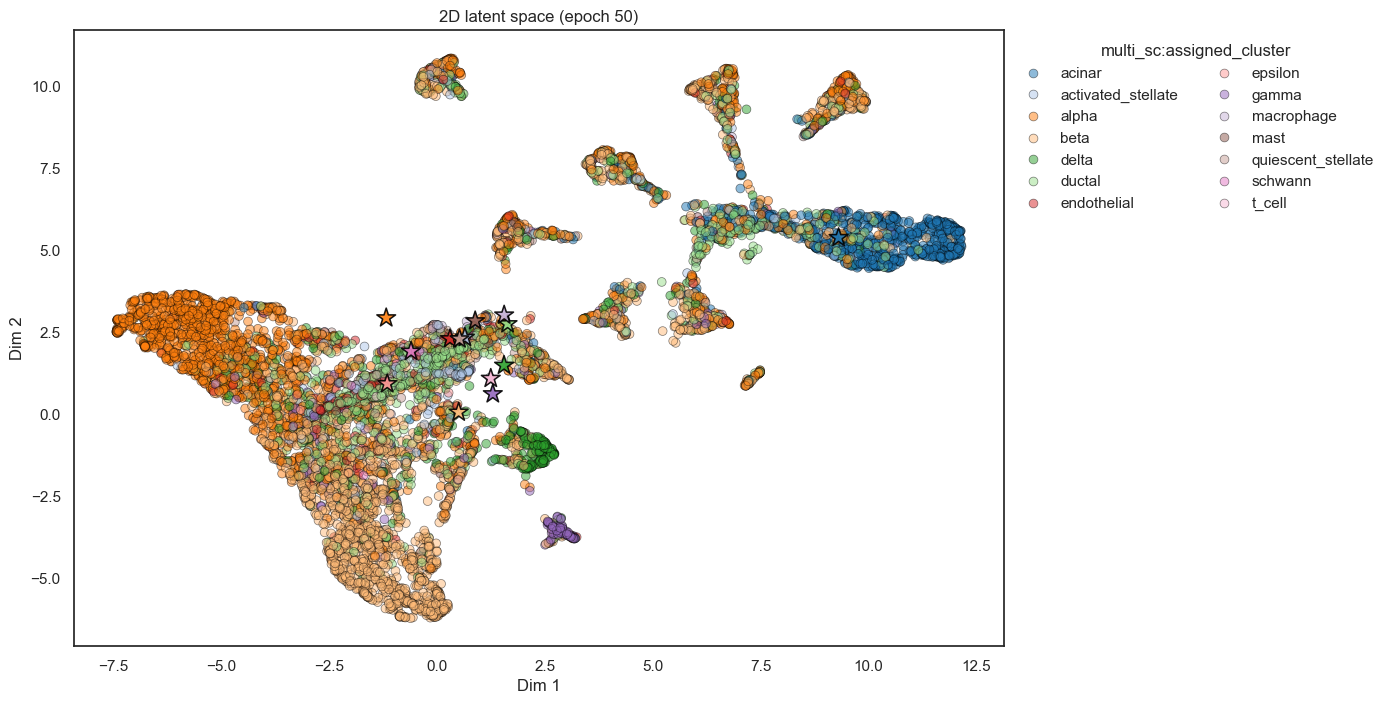

In [ ]:
maskix_zero = pipelines["0.6"]
maskix_zero.show_result()

## Adding a Custom Masking Function to `MaskixTrainer`

`MaskixTrainer` supports replacing its default corruption mechanism with a user-defined masking function. This enables experimentation with alternative masking strategies while ensuring compatibility with the trainer’s data flow.

## How to Add a Custom Masking Function

Provide your masking function at initialization:

```python
# We assume that config is defined and other imports are done (see above)

def my_masking_fn(x: torch.Tensor, strength: float = 0.2):
    noise = torch.randn_like(x) * strength
    return x + noise  # must return ONLY a single tensor in shape of input tensor

masking_fn_kwargs = {"strength": 0.1}
maskix = acx.Maskix(config=config, masking_fn, masking_fn_kwargs
)
```
## Requirements for a Custom Masking Function

A custom masking function must satisfy the following constraints:

1. **It must accept a `torch.Tensor` as the first positional argument.**  
   The trainer passes the input mini-batch `X` directly into the function.

2. **It must return exactly one value: a `torch.Tensor`.**  
   The trainer does not consume or propagate additional outputs.  
   Returning tuples or multiple values is not allowed.

3. **The returned tensor must have the same shape as the input tensor.**  
   Any shape mismatch will raise a validation error.

4. **The function must operate on the device of the input tensor.**  
   The function must not assume the tensor resides on the CPU; it must operate on the device of `x`.

5. **Any additional parameters must be passed via `masking_fn_kwargs`.**  
   These keyword arguments provide a clean separation between trainer configuration and masking logic.

### Example
This is our default masking method:
```python
    def _maskix_hook(
        self, X: torch.Tensor
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # expand probablities for bernoulli sampling to match input shape
        probs = self._mask_probas.expand(X.shape)

        # Create the Boolean Mask (1 = Swap, 0 = Keep)
        should_swap = torch.bernoulli(probs).bool()

        # COLUMN-WISE SHUFFLING
        # We generate a random float matrix and argsort it along dim=0.
        # This gives us independent random indices for every column.
        rand_indices = torch.rand(X.shape, device=X.device).argsort(dim=0)

        # Use gather to reorder X based on these random indices
        shuffled_X = torch.gather(X, 0, rand_indices)
        corrupted_X = torch.where(should_swap, shuffled_X, X)

        return corrupted_X
```



In [ ]:
import torch
import autoencodix as acx
from autoencodix.configs import MaskixConfig
from autoencodix.configs.default_config import DataInfo, DataConfig, DataCase


def my_masking_fn(x: torch.Tensor, strength: float = 0.2):
    # Noise is created with the same shape, dtype, and device as `x`
    noise = torch.randn_like(x) * strength
    return x + noise


kwargs = {"strength": 0.5}


sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")
config = MaskixConfig(
    epochs=5,
    checkpoint_interval=2,
    batch_size=64,
    data_config=DataConfig(
        annotation_columns=["multi_sc:assigned_cluster"],
        data_info={
            "multi_sc": DataInfo(
                file_path=sc_path, is_single_cell=True, data_type="NUMERIC"
            )
        },
    ),
    data_case=DataCase.MULTI_SINGLE_CELL,
)
maskix = acx.Maskix(config=config, masking_fn=my_masking_fn, masking_fn_kwargs=kwargs)

In [ ]:
result = maskix.run()

Number of common cells: 8569
Index(['barcode', 'assigned_cluster', 'sample_id'], dtype='object')
mudata: View of MuData object with n_obs × n_vars = 8569 × 20125
  obs:	'barcode', 'assigned_cluster', 'sample_id'
  1 modality
    multi_sc:	8569 x 20125
      obs:	'barcode', 'assigned_cluster', 'sample_id'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/losses/maskix_loss.py:38: UserWarning: You chose loss reduction: sum, this deviates from the implementation in the literature for this architecture, the authors used 'mean'
  warnings.warn(


<function my_masking_fn at 0x13f2c45e0>
Masking function output shape: torch.Size([100, 30])
Masking function input shape: torch.Size([100, 30])
Epoch 1 - Train Loss: 9.3374
Sub-losses: recon_loss: 6.8484, mask_loss: 10.4042
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Using user-defined masking function.
Epoch 1 - Valid Loss: 28.2903
Sub-losses: recon_loss: 10.7440, mask_loss: 35.8101
Epoch 2 - Train Loss: 7.0102
Sub-losses: recon_loss: 4.3256, mask_loss: 8.1608
Using user-defined masking function.
Using user-defined masking function.
Using user-defined mas

In [ ]:
enc_sizes = [64, 32, 16, 8]
enc_sizes[:-1]
enc_sizes[1:]

[32, 16, 8]

In [ ]:
from itertools import pairwise

enc_dim = [784, 256, 128, 64]

for i, (in_features, out_features) in enumerate(pairwise(enc_dim)):
    print(f"Layer {i}: {in_features} -> {out_features}")

Layer 0: 784 -> 256
Layer 1: 256 -> 128
Layer 2: 128 -> 64
